# Naive Bayes Classification (USD/UAH)

Мета: класифікувати дні з великою амплітудою/волатильністю (large move) для USD/UAH за допомогою наївного баєсівського класифікатора. Ціль: `y_vol = 1`, якщо абсолютна дохідність наступного дня перевищує обраний перцентиль (наприклад, 75-й), інакше `0`.

Постановка задачі:
- Маємо щоденні ознаки на дні t (наприклад, `return_1d`, `range_pct`, `gap_open`) і прогнозуємо, чи буде наступний день t+1 великим за амплітудою руху.
- "Великий рух" визначається порогом, обчисленим лише на тренувальній підвибірці (наприклад, 75-й перцентиль `|ret_{t+1}|`). Це уникає leakage і задає збалансованість класів.
- Оцінюємо Gaussian Naive Bayes на часовому поділі: перші 80% — train, останні 20% — test; звітуємо accuracy та ROC/AUC.

Обсяг (мінімальна лабораторна версія):
- Підготовка train/test з `datasets/` із урахуванням часу
- Інженерія фіч без витоку інформації; просте масштабування
- Формування мітки великих рухів (поріг за train лише)
- Навчання/оцінка Naive Bayes; метрики accuracy і ROC/AUC
- Мінімальні візуалізації (розподіли фіч за класом, ROC)

Примітки:
- Поріг для мітки рахується тільки на train (без витоків).
- Просунуті трейдингові утиліти навмисно опущені для стислості.


In [1]:
# Imports
import os
import math
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, RocCurveDisplay, confusion_matrix
from sklearn.naive_bayes import GaussianNB as SklearnGaussianNB

# Plot settings
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (9, 5)

# Paths
ROOT = pathlib.Path(".").resolve()
DATASET_PATHS = [
    ROOT.parent / "datasets" / "USD_UAH Historical Data.csv",
    ROOT / "02-naive-bayessian-classifier" / "api" / "datasets" / "USD_UAH Historical Data.csv",
]

# Helper to load data
def load_usd_uah(paths):
    for p in paths:
        if p.exists():
            df = pd.read_csv(p)
            return df, p
    raise FileNotFoundError("File 'USD_UAH Historical Data.csv' was not found in known paths.")

raw_df, used_path = load_usd_uah(DATASET_PATHS)
print(f"Loaded data from: {used_path}")
raw_df.head()


Loaded data from: D:\Study\ро\datasets\USD_UAH Historical Data.csv


,Date,Price,Open,High,Low,Vol.,Change %
0,10/07/2025,41.4030,41.1503,41.4030,41.1503,NaN,0.25%
1,10/06/2025,41.3000,41.3500,41.4420,41.1880,NaN,-0.12%
2,10/03/2025,41.3500,41.0859,41.3708,41.0455,NaN,0.64%
3,10/02/2025,41.0859,41.2372,41.3520,41.0680,NaN,-0.37%
4,10/01/2025,41.2372,41.1262,41.3353,41.0750,NaN,0.27%


In [2]:
# Data preparation: parse dates, sort, create features and large-move target

df = raw_df.copy()

# Parse dates in mm/dd/YYYY format and sort
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df = df.sort_values("Date").reset_index(drop=True)

# Numeric columns as float
for col in ["Price", "Open", "High", "Low"]:
	# Replace potential commas and cast to float (protect against locales)
	df[col] = (
		df[col]
		.astype(str)
		.str.replace(",", "", regex=False)
		.astype(float)
	)

# Feature engineering from daily moves/volatility (t, t-1)
# Basic features
df["return_1d"] = df["Price"].pct_change()
df["range_pct"] = (df["High"] - df["Low"]) / df["Open"].replace(0, np.nan)
df["gap_open"] = df["Open"].pct_change()

# Additional volatility features
df["return_2d"] = df["Price"].pct_change(2)
df["return_3d"] = df["Price"].pct_change(3)
df["rolling_std_5"] = df["return_1d"].rolling(5, min_periods=3).std()
df["rolling_std_10"] = df["return_1d"].rolling(10, min_periods=5).std()

# ATR (Average True Range) - simplified version
df["tr"] = np.maximum(
    df["High"] - df["Low"],
    np.maximum(
        np.abs(df["High"] - df["Price"].shift(1)),
        np.abs(df["Low"] - df["Price"].shift(1))
    )
)
df["atr_5"] = df["tr"].rolling(5, min_periods=3).mean() / df["Price"]
df["atr_10"] = df["tr"].rolling(10, min_periods=5).mean() / df["Price"]

# Absolute gap
df["abs_gap"] = np.abs(df["gap_open"])
df["abs_return"] = np.abs(df["return_1d"])

# Build tomorrow's absolute return and range (for label construction only)
df["ret_tomorrow"] = df["Price"].shift(-1) / df["Price"] - 1.0

# Time-aware split index (80/20)
n = len(df)
split_idx = int(n * 0.8)

# Percentile threshold computed on TRAIN ONLY (no leakage)
train_abs_ret = df.loc[:split_idx-1, "ret_tomorrow"].abs().dropna()
pct = 0.75
thr = float(np.quantile(train_abs_ret, pct)) if len(train_abs_ret) > 0 else float(train_abs_ret.mean())

# Large-move label: 1 if |ret_{t+1}| >= thr, else 0
df["y_vol"] = (df["ret_tomorrow"].abs() >= thr).astype(int)

# Final modeling dataset (features at t, label about t+1)
feature_cols = [
    "return_1d", "range_pct", "gap_open",
    "return_2d", "return_3d",
    "rolling_std_5", "rolling_std_10",
    "atr_5", "atr_10",
    "abs_gap", "abs_return"
]
use_cols = feature_cols + ["ret_tomorrow", "y_vol"]
df = df.dropna(subset=use_cols).reset_index(drop=True)

X_all = df[feature_cols].values
y_all = df["y_vol"].values

print({"train_threshold_abs_return@75%": round(thr, 5), "positives": int(y_all.sum()), "negatives": int(len(y_all) - y_all.sum())})
print(df[["Date", "Price", "return_1d", "range_pct", "gap_open", "ret_tomorrow", "y_vol"]].tail())
print(f"Number of observations after preparation: {len(df)}")


{'train_threshold_abs_return@75%': 0.00329, 'positives': 104, 'negatives': 352}
          Date    Price  return_1d  range_pct  gap_open  ret_tomorrow  y_vol
451 2025-09-30  41.1262  -0.003262   0.008926 -0.002760      0.002699      0
452 2025-10-01  41.2372   0.002699   0.006329 -0.003262     -0.003669      1
453 2025-10-02  41.0859  -0.003669   0.006887  0.002699      0.006428      1
454 2025-10-03  41.3500   0.006428   0.007918 -0.003669     -0.001209      0
455 2025-10-06  41.3000  -0.001209   0.006143  0.006428      0.002494      0
Number of observations after preparation: 456


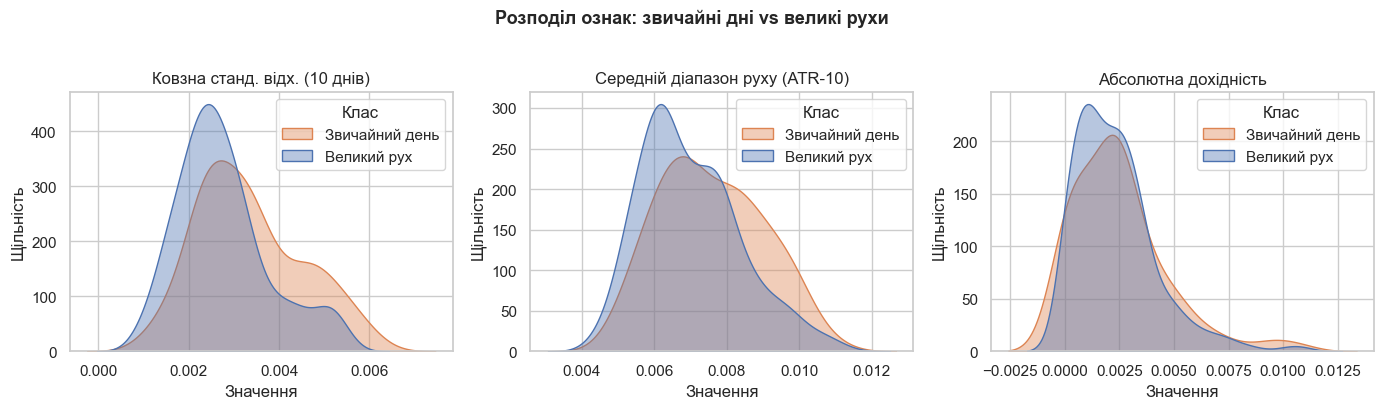

In [3]:
# Розподіл найважливіших ознак волатильності за класами

top_features = ["rolling_std_10", "atr_10", "abs_return"]
feature_names = {
    "rolling_std_10": "Ковзна станд. відх. (10 днів)",
    "atr_10": "Середній діапазон руху (ATR-10)",
    "abs_return": "Абсолютна дохідність"
}

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, col in enumerate(top_features):
	ax = axes[i]
	sns.kdeplot(data=df, x=col, hue="y_vol", fill=True, common_norm=False, alpha=0.4, ax=ax)
	ax.set_title(feature_names[col])
	ax.set_xlabel("Значення")
	ax.set_ylabel("Щільність")
	ax.legend(["Звичайний день", "Великий рух"], title="Клас")
plt.suptitle("Розподіл ознак: звичайні дні vs великі рухи", y=1.02, fontsize=13, weight='bold')
plt.tight_layout()
plt.show()


In [4]:
# Time-ordered train/test split + standardization

# Use the first 80% as train, last 20% as test (time-aware)
X_train, y_train = X_all[:split_idx], y_all[:split_idx]
X_test, y_test = X_all[split_idx:], y_all[split_idx:]

# Standardization
mu_tr = X_train.mean(axis=0)
sig_tr = X_train.std(axis=0) + 1e-9
X_train_z = (X_train - mu_tr) / sig_tr
X_test_z = (X_test - mu_tr) / sig_tr

# Check actual class distribution
class_counts = np.bincount(y_train)
print(f"Train class distribution: class 0={class_counts[0]}, class 1={class_counts[1]}")
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")


Train class distribution: class 0=277, class 1=92
Train size: 369, Test size: 87
Features: 11


In [5]:
# In-house Gaussian Naive Bayes implementation (with sample_weight support)

class InHouseGNB:
	def __init__(self, reg_param: float = 1e-6):
		self.reg_param = float(reg_param)
		self.classes_ = None
		self.priors_ = None
		self.means_ = None
		self.vars_ = None

	def fit(self, X: np.ndarray, y: np.ndarray, sample_weight=None):
		X = np.asarray(X, dtype=float)
		y = np.asarray(y)
		
		if sample_weight is None:
			sample_weight = np.ones(len(y))
		else:
			sample_weight = np.asarray(sample_weight, dtype=float)
		
		self.classes_ = np.unique(y)
		n_classes = len(self.classes_)
		n_features = X.shape[1]

		# Weighted priors with boosting for minority class
		weighted_counts = np.array([sample_weight[y == cls].sum() for cls in self.classes_])
		# Apply extra boost to minority class (class 1): multiply by 2.5
		if len(weighted_counts) == 2:
			weighted_counts[1] *= 2.5
		self.priors_ = weighted_counts / weighted_counts.sum()
		
		self.means_ = np.zeros((n_classes, n_features), dtype=float)
		self.vars_ = np.zeros((n_classes, n_features), dtype=float)

		# Compute class means and variances
		for idx, cls in enumerate(self.classes_):
			mask = (y == cls)
			Xc = X[mask]
			wc = sample_weight[mask]
			self.means_[idx] = np.average(Xc, axis=0, weights=wc)
			# Weighted variance
			centered = Xc - self.means_[idx]
			weighted_var = np.average(centered**2, axis=0, weights=wc)
			self.vars_[idx] = weighted_var + self.reg_param
		
		return self

	def _log_gaussian_likelihood(self, X: np.ndarray, cls_idx: int) -> np.ndarray:
		X = np.asarray(X, dtype=float)
		if X.ndim == 1:
			X = X.reshape(1, -1)
		mean = self.means_[cls_idx]
		var = self.vars_[cls_idx]
		# log N(x|mu, var) = -0.5 * [log((2π)^d |Σ|) + (x-μ)^T Σ^{-1} (x-μ)]
		log_det = np.sum(np.log(2.0 * np.pi * var))
		sq = np.sum(((X - mean) ** 2) / var, axis=1)
		return -0.5 * (log_det + sq)

	def predict_log_proba(self, X: np.ndarray) -> np.ndarray:
		X = np.asarray(X, dtype=float)
		log_probs = []
		for idx, _ in enumerate(self.classes_):
			log_prior = np.log(self.priors_[idx] + 1e-9)
			log_likelihood = self._log_gaussian_likelihood(X, idx)
			log_probs.append(log_prior + log_likelihood)
		return np.vstack(log_probs).T  # shape (n_samples, n_classes)

	def predict_proba(self, X: np.ndarray) -> np.ndarray:
		log_p = self.predict_log_proba(X)
		# log-sum-exp for normalization
		max_log = np.max(log_p, axis=1, keepdims=True)
		stabilized = np.exp(log_p - max_log)
		return stabilized / stabilized.sum(axis=1, keepdims=True)

	def predict(self, X: np.ndarray) -> np.ndarray:
		proba = self.predict_proba(X)
		idx = np.argmax(proba, axis=1)
		return self.classes_[idx]



In [6]:
# Train in-house GNB with sample weights and regularization

from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train)

in_gnb = InHouseGNB(reg_param=1e-3).fit(X_train_z, y_train, sample_weight=sample_weights)

# Sklearn GaussianNB
sk_gnb = SklearnGaussianNB()
sk_gnb.fit(X_train_z, y_train)

# Override priors for sklearn: give MORE weight to class 1 (70% prior for minority class)
sk_gnb.class_prior_ = np.array([0.3, 0.7])

# Predict
sk_pred = sk_gnb.predict(X_test_z)
in_pred = in_gnb.predict(X_test_z)

# Probabilities (class 1)
sk_proba = sk_gnb.predict_proba(X_test_z)[:, 1]
in_proba = in_gnb.predict_proba(X_test_z)[:, 1]

print(f"Priors applied for sklearn: {sk_gnb.class_prior_}")
print(f"Priors applied for InHouse: {in_gnb.priors_}")


Priors applied for sklearn: [0.3 0.7]
Priors applied for InHouse: [0.28571429 0.71428571]


In [7]:
# Metrics: sklearn GNB vs In-house GNB (with threshold tuning for InHouse)

# Find optimal threshold for InHouse GNB (maximize F1)
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = []
for t in thresholds:
	pred_t = (in_proba >= t).astype(int)
	f1_scores.append(f1_score(y_test, pred_t, zero_division=0))

best_threshold = thresholds[np.argmax(f1_scores)]
in_pred_tuned = (in_proba >= best_threshold).astype(int)

print(f"Best threshold for InHouse GNB (max F1): {best_threshold:.3f}")

# Basic metrics (default threshold 0.5)
metrics = {
	"acc_sklearn": float(accuracy_score(y_test, sk_pred)),
	"acc_inhouse": float(accuracy_score(y_test, in_pred)),
	"acc_inhouse_tuned": float(accuracy_score(y_test, in_pred_tuned)),
	"bal_acc_sklearn": float(balanced_accuracy_score(y_test, sk_pred)),
	"bal_acc_inhouse": float(balanced_accuracy_score(y_test, in_pred)),
	"bal_acc_inhouse_tuned": float(balanced_accuracy_score(y_test, in_pred_tuned)),
	"precision_sklearn": float(precision_score(y_test, sk_pred, zero_division=0)),
	"precision_inhouse": float(precision_score(y_test, in_pred, zero_division=0)),
	"precision_inhouse_tuned": float(precision_score(y_test, in_pred_tuned, zero_division=0)),
	"recall_sklearn": float(recall_score(y_test, sk_pred, zero_division=0)),
	"recall_inhouse": float(recall_score(y_test, in_pred, zero_division=0)),
	"recall_inhouse_tuned": float(recall_score(y_test, in_pred_tuned, zero_division=0)),
	"f1_sklearn": float(f1_score(y_test, sk_pred, zero_division=0)),
	"f1_inhouse": float(f1_score(y_test, in_pred, zero_division=0)),
	"f1_inhouse_tuned": float(f1_score(y_test, in_pred_tuned, zero_division=0)),
}

# AUC via ROC
fpr_sk, tpr_sk, _ = roc_curve(y_test, sk_proba)
auc_sk = auc(fpr_sk, tpr_sk)

fpr_in, tpr_in, _ = roc_curve(y_test, in_proba)
auc_in = auc(fpr_in, tpr_in)

metrics.update({
	"auc_sklearn": float(auc_sk),
	"auc_inhouse": float(auc_in),
})

print("\nMetrics comparison:")
print(metrics)


Best threshold for InHouse GNB (max F1): 0.198

Metrics comparison:
{'acc_sklearn': 0.7701149425287356, 'acc_inhouse': 0.7586206896551724, 'acc_inhouse_tuned': 0.3793103448275862, 'bal_acc_sklearn': 0.4816666666666667, 'bal_acc_inhouse': 0.47500000000000003, 'bal_acc_inhouse_tuned': 0.5700000000000001, 'precision_sklearn': 0.1, 'precision_inhouse': 0.09090909090909091, 'precision_inhouse_tuned': 0.16129032258064516, 'recall_sklearn': 0.08333333333333333, 'recall_inhouse': 0.08333333333333333, 'recall_inhouse_tuned': 0.8333333333333334, 'f1_sklearn': 0.09090909090909091, 'f1_inhouse': 0.08695652173913043, 'f1_inhouse_tuned': 0.2702702702702703, 'auc_sklearn': 0.5277777777777778, 'auc_inhouse': 0.5277777777777778}


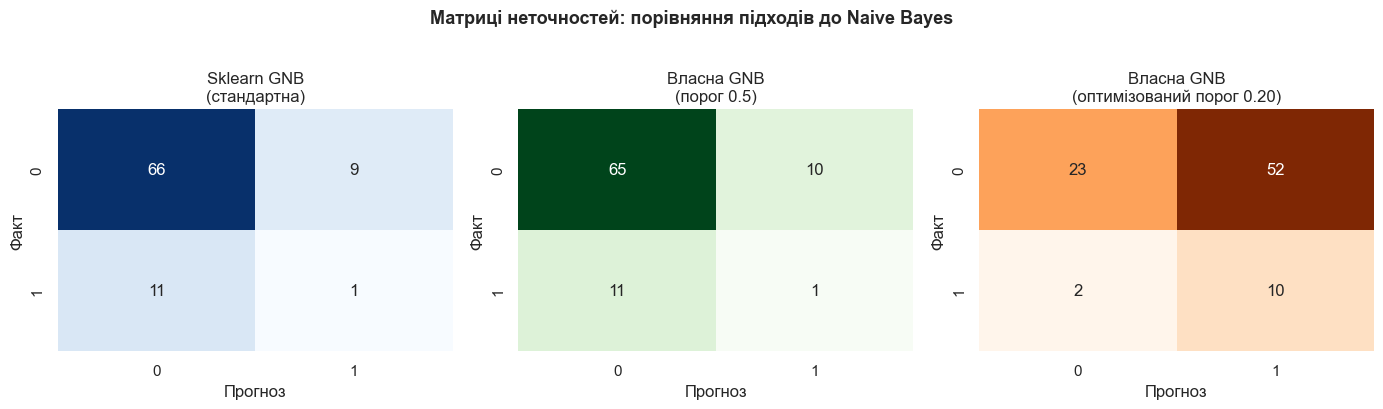

In [8]:
# Матриці неточностей (порівняння моделей)

cm_sk = confusion_matrix(y_test, sk_pred)
cm_in = confusion_matrix(y_test, in_pred)
cm_in_tuned = confusion_matrix(y_test, in_pred_tuned)

fig, axes = plt.subplots(1, 3, figsize=(14,4))
sns.heatmap(cm_sk, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Sklearn GNB\n(стандартна)')
axes[0].set_xlabel('Прогноз'); axes[0].set_ylabel('Факт')

sns.heatmap(cm_in, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title('Власна GNB\n(порог 0.5)')
axes[1].set_xlabel('Прогноз'); axes[1].set_ylabel('Факт')

sns.heatmap(cm_in_tuned, annot=True, fmt='d', cmap='Oranges', ax=axes[2], cbar=False)
axes[2].set_title(f'Власна GNB\n(оптимізований порог {best_threshold:.2f})')
axes[2].set_xlabel('Прогноз'); axes[2].set_ylabel('Факт')

plt.suptitle("Матриці неточностей: порівняння підходів до Naive Bayes", y=1.02, fontsize=13, weight='bold')
plt.tight_layout(); plt.show()


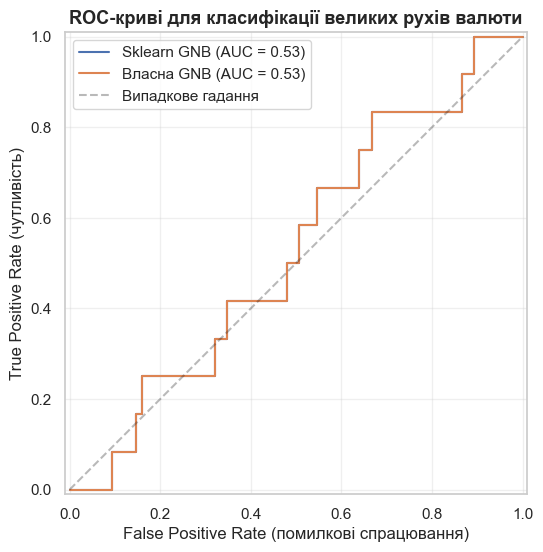

In [9]:
# ROC-криві: порівняння sklearn vs власна реалізація

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay(fpr=fpr_sk, tpr=tpr_sk, roc_auc=auc_sk, estimator_name="Sklearn GNB").plot(ax=ax)
RocCurveDisplay(fpr=fpr_in, tpr=tpr_in, roc_auc=auc_in, estimator_name="Власна GNB").plot(ax=ax)
ax.plot([0, 1], [0, 1], 'k--', label='Випадкове гадання', alpha=0.3)
plt.title("ROC-криві для класифікації великих рухів валюти", fontsize=13, weight='bold')
plt.xlabel("False Positive Rate (помилкові спрацювання)")
plt.ylabel("True Positive Rate (чутливість)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
